In [6]:
cd /data/store01/data_dirs/students/ucfafyi/S2_MODIS

/data/store01/data_dirs/students/ucfafyi/S2_MODIS


In [39]:
import os
import sys
sys.path.insert(0, 'python')
import numpy as np
from read_net import *
from fastRWpkl import *
import multiprocessing
from functools import partial
import gdal
from L_geo import *
from get_brdf import *
from geo_trans import *
import glob
from scipy import ndimage, signal, optimize
import scipy
from elevation import elevation
from get_wrs import *
import tifffile
import scipy.stats as stats
from mgrspy import mgrs as mg
from smoothn import *
from Py6S import *

directory = os.getcwd()+'/'

def ScaleExtent(data, shape =(10980, 10980)): # used for unifine different array,     
        re = int(shape[0]/(data.shape[0]))
        return np.repeat(np.repeat(data, re, axis = 1), re, axis =0)

def fun(f, q_in, q_out):
    while True:
        i, x = q_in.get()
        if i is None:
            break
        q_out.put((i, f(x)))
        
rsr = PredefinedWavelengths.LANDSAT_OLI_B2,PredefinedWavelengths.LANDSAT_OLI_B3,PredefinedWavelengths.LANDSAT_OLI_B4, \
        PredefinedWavelengths.LANDSAT_OLI_B5, PredefinedWavelengths.LANDSAT_OLI_B6, PredefinedWavelengths.LANDSAT_OLI_B7        
def atm(p, RSR=None):
    #print len(p[0])
    # ele in km
    #print  len(p[0])
    TOA_ref, aot550, water, ozone, sz, vz, raa , ele= p
    path = '/home/ucfafyi/DATA/Downloads/6SV2.1/sixsV2.1'
    s = SixS(path)
    ss = []
    s = SixS(path)
    s.altitudes.set_target_custom_altitude(ele)
    s.altitudes.set_sensor_satellite_level()
    s.ground_reflectance = GroundReflectance.HomogeneousLambertian(GroundReflectance.GreenVegetation)
    s.geometry = Geometry.User()
    s.geometry.solar_a = 0
    s.geometry.solar_z = np.arcsin(sz)*180/np.pi
    s.geometry.view_a = np.arccos(raa)*180/np.pi
    s.geometry.view_z = np.arcsin(vz)*180/np.pi
    s.aero_profile = AeroProfile.PredefinedType(AeroProfile.Continental)
    s.aot550 = aot550
    s.atmos_profile = AtmosProfile.UserWaterAndOzone(water, ozone)
    s.wavelength = Wavelength(RSR)
    #s.atmos_corr = AtmosCorr.AtmosCorrLambertianFromReflectance(TOA_ref)
    s.run()      
    return s

def parmap(f, X, nprocs=multiprocessing.cpu_count()):
    q_in = multiprocessing.Queue(1)
    q_out = multiprocessing.Queue()

    proc = [multiprocessing.Process(target=fun, args=(f, q_in, q_out))
            for _ in range(nprocs)]
    for p in proc:
        p.daemon = True
        p.start()

    sent = [q_in.put((i, x)) for i, x in enumerate(X)]
    [q_in.put((None, None)) for _ in range(nprocs)]
    res = [q_out.get() for _ in range(len(sent))]

    [p.join() for p in proc]

    return [x for i, x in sorted(res)]

class Aerosol_retrival(object):
    
    def __init__(self, L8_fname=None, aot_site=None, lat=None, \
                 lon=None, path=None, row=None, L8_month=None, L8_day=None, \
                 S2_fname=None, year=None, S2_month=None, S2_day=None, S2_psf=None, L8_psf=None):
        
        self.aot_site = aot_site
        self.year = int(year)
        self.L8_fname = L8_fname
        if L8_month != None:
            self.L8_month = int(L8_month)
            self.L8_day= int(L8_day)
            self.L8_doy = datetime.datetime(self.year, self.L8_month, self.L8_day).timetuple().tm_yday
            self.path = int(path)
            self.row = int(row)
            self.L8_psf =L8_psf
        
        self.S2_fname = S2_fname
        if S2_month != None:
            self.S2_month = int(S2_month)
            self.S2_day= int(S2_day)
            self.S2_doy = datetime.datetime(self.year, self.S2_month, self.S2_day).timetuple().tm_yday
            self.S2_psf = S2_psf
        
        self.lat = float(lat)
        self.lon = float(lon)
        self.h, self.v = mtile_cal(self.lat, self.lon)
        self._alpha = 1.42 #angstrom exponent for continental type aerosols
    
    def read_meta(self, Hfile, path=None, row=None):
    
        with open(Hfile.split('_toa_')[0]+'_MTL.txt', 'r') as inF:
            for line in inF:
                if 'CLOUD_COVER ' in line:
                    cloud_cover =  float(line.split('= ')[1])
        if cloud_cover<20:
            #print 'Less than 20% cloud.'
            b1 = gdal.Open(Hfile+'band1.tif').ReadAsArray()
            corners = b1.shape
            dic = {}
            with open(Hfile.split('_toa_')[0]+'_MTL.txt', 'r') as inF:
                for line in inF:
                    if ('CORNER_' in line)&('LAT_PRODUCT' in line):
                        dic[line.split(' = ')[0].strip()[7:13]] = float(line.split(' = ')[1])
                    elif ('CORNER_' in line)&('LON_PRODUCT' in line):
                        dic[line.split(' = ')[0].strip()[7:13]] = float(line.split(' = ')[1])
                    elif 'ROLL_ANGLE' in line:
                        vza = float(line.split(' = ')[1])
                    elif 'SUN_AZIMUTH' in line:
                        saa = float(line.split(' = ')[1])
                    elif 'SUN_ELEVATION' in line:
                        sza = float(line.split(' = ')[1])
            with open('Landsat_azm.pkl', 'r') as savefile:
                Landsat_azm = pkl.load(savefile)

            vaa = np.nanmean(Landsat_azm[(Landsat_azm[:,2]==path)&(Landsat_azm[:,3]==row)].squeeze()[:2])

            return sza, saa, vza, vaa, dic, corners
        else:
            print 'To much cloud: ', cloud_cover
            return []     
        
       
    def L8_aot(self):
        self.wl = np.array([482.04,561.41,654.59,864.67,1608.86,2200.73])/1000
        self.bands = [2,3,4,5,6,7]
        pr=get_wrs(self.lat, self.lon)
        self.path, self.row = pr[0]['path'],pr[0]['row']
        self.Hfile = directory +'l_data/%s_toa_'%(self.L8_fname)
        self.Lfile = glob.glob('m_data/MCD43A1.A%d%03d.h%02dv%02d.006.*.hdf'%(self.year, self.L8_doy,self.h,self.v))[0]
        self.sza, self.saa, self.vza, self.vaa, self.dic, self.corners = self.read_meta(self.Hfile, self.path, self.row)
        self.L_inds, self.H_inds = MSL_geo_trans(self.lat, self.lon, self.dic, self.corners)
        self.Lx, self.Ly = self.L_inds
        self.Hx, self.Hy = self.H_inds
        self.angles = np.zeros((3,6))
        self.angles[0,:] = self.sza
        self.angles[1,:] = self.vza
        self.angles[2,:] = self.vaa-self.saa
        
        if glob.glob(self.Lfile+'_L8_aoi_brdf.pkl')==[]:
            self.brdf, self.qa = get_brdf_six(self.Lfile, (self.angles[0], self.angles[1], self.angles[2]),\
                                              bands=[3,4,1,2,6,7], flag=None, Linds= self.L_inds)
            pkl.dump(np.array([self.brdf, self.qa]), open(self.Lfile+'_L8_aoi_brdf.pkl', 'w'))
            
        else:
            self.brdf, self.qa = pkl.load(open(self.Lfile+'_L8_aoi_brdf.pkl', 'r'))
        
        cloud = gdal.Open(self.Hfile[:-5]+'_cfmask.tif').ReadAsArray()
        cl_mask = cloud==4 # cloud pixels; strictest way is to set the clear pixels with cloud==0
        struct = ndimage.generate_binary_structure(2, 2)
        self.dia_cloud = ndimage.binary_dilation(cl_mask, structure=struct, iterations=20).astype(cl_mask.dtype)
        
        shape =  self.dia_cloud.shape
        xstd,ystd, angle, xs, ys = self.L8_psf[:5]
        self.shx, self.shy = (self.Hx+xs).astype(int), (self.Hy+ys).astype(int)
        self.val = (self.Hx+xs<shape[0])&(self.Hy+ys<shape[1])&(self.Hx+xs>0)&(self.Hy+ys>0)
        self.ker = self.gaussian(xstd,ystd,angle,True)
        retval = parmap(self.L8_get_to_cor, self.bands, nprocs=len(self.bands))

        self.L8_mask = np.array(retval)[:,1,:].astype(bool)
        self.L8_data = np.array(retval)[:,0,:]
        
        Mcomb_mask = np.all(self.qa<2, axis=0)
        Lcomb_mask = np.all(self.L8_mask, axis = 0)
        
        l8 = self.L8_data.copy()
        br = self.brdf.copy()
        l8[:,(~Lcomb_mask)|(~Mcomb_mask[self.val])]=np.nan
        l8[np.isnan(l8)], br[np.isnan(br)] = -9999999, -9999999
        mas = np.all((br[:,self.val]>0)&(br[:,self.val]<1)&(l8>0)&(l8<1), axis=0)
        self.to_cor = self.shx[self.val][mas], self.shy[self.val][mas],l8[:,mas], br[:,self.val][:,mas]
        
        dif = aot.to_cor[3]-aot.to_cor[2]
        u,d = dif.mean(axis=1)+ 3*dif.std(axis=1), dif.mean(axis=1)- 3*dif.std(axis=1)
        in_mask = np.all(np.array([(dif[i]>d[i])&(dif[i]<u[i]) for i in range(len(dif))]), axis=0)
        
        self.to_cor = self.shx[self.val][mas][in_mask], self.shy[self.val][mas][in_mask], l8[:,mas][:,in_mask], br[:,self.val][:,mas][:, in_mask]
          
        self.emus = parallel_rw_pkl(None, '6S_emulation_L8_', 'r')

        self.w = (np.array(self.wl))**(-self._alpha)
        self.w = self.w/self.w.sum()
        
        self.patch_pixs = 300.
        patches = []        
        self.inds = []
        indx, indy = self.to_cor[:2]
        for i in np.arange(0, np.ceil(shape[0]/self.patch_pixs)):
            for j in np.arange(0, np.ceil(shape[1]/self.patch_pixs)):
                patch_mask = (indx>i*self.patch_pixs) & (indx<(i+1)*self.patch_pixs)\
                & (indy>j*self.patch_pixs) & (indy<(j+1)*self.patch_pixs)
                patches.append(self._l8_opt(i, j, patch_mask))
                self.inds.append([i,j])
                
        self.inds = np.array(self.inds)
        paras = np.array([i[0] for i in patches])
        cost = np.array([i[1] for i in patches]).reshape(self.inds[:,0].max()+1,self.inds[:,1].max()+1)
        aot_mask = (np.array(paras[:,0]).reshape(cost.shape)==0) | np.isnan(cost)
        twv_mask = (np.array(paras[:,1]).reshape(cost.shape)==0) | np.isnan(cost)
        w1 = np.zeros_like(cost)
        w2 = np.zeros_like(cost)
        w1[~aot_mask] = np.abs(1./cost[~aot_mask])
        w2[~twv_mask] = np.abs(1./cost[~twv_mask])
        aot_map = np.zeros_like(cost)
        twv_map = np.zeros_like(cost)
        aot_map[aot_mask] = paras[:,0].reshape(cost.shape)[~aot_mask].mean()
        twv_map[twv_mask] = paras[:,1].reshape(cost.shape)[~twv_mask].mean()
        aot_map[~aot_mask] = paras[:,0].reshape(cost.shape)[~aot_mask]
        twv_map[~twv_mask] = paras[:,1].reshape(cost.shape)[~twv_mask]
        smed_aot = smoothn(aot_map,s=0.5, W=w1**2, isrobust=True)
        smed_twv = smoothn(twv_map, s=0.5, W=w2**2, isrobust=True)
        self.aot_map, self.twv_map = smed_aot[0], smed_twv[0]
        
        tifffile.imsave( self.Hfile+'aot.tiff', self.aot_map)
        tifffile.imsave( self.Hfile+'tcw.tiff', self.twv_map)
        
        return self.aot_map, self.twv_map, paras, cost
       
    def _l8_opt(self, indx,indy, patch_mask):
        
        if np.all(~patch_mask):
            px, py = np.mgrid[indx*self.patch_pixs: (indx+1)*self.patch_pixs, indy*self.patch_pixs: (indy+1)*self.patch_pixs]
            pix_lat, pix_lon = cor_inter(np.array([px.ravel(), py.ravel()]), self.dic, self.corners)
            eles = np.mean(elevation(pix_lat, pix_lon)/1000.)
        else:
            pix_lat, pix_lon = cor_inter(np.array([self.to_cor[0][patch_mask],\
                                                   self.to_cor[1][patch_mask]]), self.dic, self.corners)
            eles = elevation(pix_lat, pix_lon)/1000.
        self.ECWMF_aot = np.mean(read_net(self.year,\
                                       self.L8_month,self.L8_day, np.arange(pix_lat.min(), pix_lat.max()+0.125, 0.125),\
                                       np.arange(pix_lon.min(),pix_lon.max()+0.125, 0.125), dataset='aot'))
        
        self.ECWMF_twv = np.mean(read_net(self.year,\
                                       self.L8_month,self.L8_day, np.arange(pix_lat.min(), pix_lat.max()+0.125, 0.125),\
                                       np.arange(pix_lon.min(),pix_lon.max()+0.125, 0.125), dataset='wv'))
        
        self.ECWMF_tco = np.mean(read_net(self.year,\
                                       self.L8_month,self.L8_day, np.arange(pix_lat.min(), pix_lat.max()+0.125, 0.125),\
                                       np.arange(pix_lon.min(),pix_lon.max()+0.125, 0.125), dataset='tco'))
        angles =[i*np.pi/180 for i in [self.sza, self.saa, self.vza, self.vaa]]
        args = angles, eles, self.ECWMF_tco*46.698, patch_mask
        bounds = ((0.,1.),(0.,5.))
        
        p0 = self.ECWMF_aot, self.ECWMF_twv/10.
        psolve = optimize.fmin_l_bfgs_b(self._cost,p0, approx_grad=0, iprint=1, bounds=bounds,fprime=None,args=(args,))
        
        return psolve
    
    def _cost(self, p, args = None):
        aot550, water = p
        angles, eles, ozone, patch_mask = args        
        sz, sa, vz, va = angles        
        pas = [self.to_cor[2][:,patch_mask], aot550, water, ozone, np.sin(sz), np.sin(vz), np.cos(sa-va), eles]

        pix_num = len(self.to_cor[2][0, patch_mask])

        paras =  np.zeros((len(self.bands), pix_num, 8))
        for i in range(len(pas)):
            if np.array(pas[i]).shape==(7,):
                dat = np.repeat(pas[1], axis=0, repeats= pix_num)
                paras[:,:,i] =  dat
            else:
                paras[:,:,i] =  pas[i]

        J = 0
        J_prime = np.zeros(2)
        for i in range(6):
            fwd, grad = self.emus[i][0].predict(paras[i], do_unc=0)
            # select from set of gradients
            g0,g1 = grad[:,1],grad[:,2]
            residual = np.array(fwd-self.to_cor[3][i, patch_mask])
            J_prime_wrt0_i = self.w[i] * residual * g0 
            J_prime_wrt1_i = self.w[i] * residual * g1
            J_i = 0.5 *self.w[i] * (residual**2)[:].sum()
            J += J_i
            J_prime += np.array([J_prime_wrt0_i,J_prime_wrt1_i])[:,:].sum(axis=1)

        return 1.*J/pix_num , J_prime
    
    
    def L8_cor(self,save=True):
        self.bands = [2,3,4,5,6,7]
        self.Hfile = directory +'l_data/%s_toa_'%(self.L8_fname)
        self.patch_pixs=300
        self.sza, self.saa, self.vza, self.vaa, self.dic, self.corners = self.read_meta(self.Hfile, self.path, self.row)
        if glob.glob(self.Hfile+'aot.tiff')==[]:
            self.aot_map, self.twv_map = self.L8_aot()
        else:
            self.aot_map = tifffile.imread(self.Hfile+'aot.tiff')
            self.twv_map = tifffile.imread(self.Hfile+'tcw.tiff')
        
        gridx, gridy = np.mgrid[0:self.aot_map.shape[0]:1, 0:self.aot_map.shape[1]:1]
        self.emus = parallel_rw_pkl(None, '6S_emulation_S2_', 'r')
        self.inds = np.array(zip(gridx.ravel(), gridy.ravel()))
        
        retval = parmap(self.L8_patch_correction, self.inds, nprocs=10)
        
        self.L8_cored = np.zeros((6,self.corners[0],self.corners[1]))
        
        for _,ind in enumerate(self.inds):
            self.L8_cored[:,ind[0]*self.patch_pixs:(ind[0]+1)*self.patch_pixs,\
                          ind[1]*self.patch_pixs:(ind[1]+1)*self.patch_pixs] = retval[_][1]
        if save:
            print 'Saving surface reflectance....'
            for i,band in enumerate(self.bands):
                tifffile.imsave(self.Hfile+'sur_ref_band%d.tiff'%band, self.L8_cored[i])
        return self.L8_cored
        
    
    def L8_patch_correction(self, inds):
        ix,iy=inds
        toa_refs = []
        #self.Hfile = directory +'l_data/%s_toa_'%(self.L8_fname)
        #self.aot_map = tifffile.imread(self.Hfile+'aot.tiff')
        #self.twv_map = tifffile.imread(self.Hfile+'tcw.tiff')
        #self.bands = [2,3,4,5,6,7]
        #self.emus = parallel_rw_pkl(None, '6S_emulation_S2_', 'r')
        #self.patch_pixs=300
        #self.sza, self.saa, self.vza, self.vaa, self.dic, self.corners = self.read_meta(self.Hfile, self.path, self.row)
        for _,band in enumerate(self.bands):

            fname = self.Hfile + 'band%s.tif'%band
            yoff, xoff = min(self.corners[1]-iy*self.patch_pixs, 300), min(self.corners[0]-ix*self.patch_pixs, 300)
            data = gdal.Open(fname).ReadAsArray(iy*self.patch_pixs,ix*self.patch_pixs,\
                                                yoff, xoff)*0.0001
            toa_refs.append(data)
        
        toa_refs = np.array(toa_refs)
        
        toa_refs[toa_refs<0] = np.nan
        px, py = np.mgrid[ix*self.patch_pixs: (ix+1)*self.patch_pixs, iy*self.patch_pixs: (iy+1)*self.patch_pixs]
        pix_lat, pix_lon = cor_inter(np.array([px.ravel(), py.ravel()]), self.dic, self.corners)
        ele = max(mean(elevation(pix_lat, pix_lon)/1000.), 0)
        

        aot = self.aot_map[ix,iy]
        twv = self.twv_map[ix,iy]
        tco = mean(read_net(self.year,\
                            self.L8_month,self.L8_day, np.arange(pix_lat.min(), pix_lat.max()+0.125, 0.125),\
                            np.arange(pix_lon.min(),pix_lon.max()+0.125, 0.125), dataset='tco'))

        p = [0.2, aot,  twv, tco*46.698, np.sin(self.sza*np.pi/180),\
               np.sin(self.vza*np.pi/180), np.cos((self.saa-self.vaa)*np.pi/180), ele]

        Sur_REF = []
        for band in range(6):
            s = atm(p, rsr[band])
            a,b,c = s.outputs.atmospheric_intrinsic_reflectance, s.outputs.transmittance_total_scattering.total, s.outputs.spherical_albedo.total
            cored = (np.array(toa_refs)[band]-a)/(b+(np.array(toa_refs)[band]-a)*c)
            Sur_REF.append(cored)
        Sur_REF = np.array(Sur_REF)
        Sur_REF[Sur_REF<0]=0.0001
        Sur_REF[Sur_REF>1]=1

        return [inds, Sur_REF]
    
    def L8_get_to_cor(self, band):
        fname = self.Hfile + 'band%s.tif'%band
        data = gdal.Open(fname).ReadAsArray()*0.0001
        mask = ~(data<=0).astype('bool')
        struct = ndimage.generate_binary_structure(2, 2)
        small_mask = ndimage.binary_erosion(mask, structure=struct, iterations=20).astype(mask.dtype)
        val_mask = (~self.dia_cloud)&small_mask
        used_mask = val_mask[self.shx[self.val], self.shy[self.val]]
        used_data = signal.fftconvolve(data, self.ker, mode='same')[self.shx[self.val], self.shy[self.val]]
        return used_data, used_mask 
        
        
    def gaussian(self, xstd, ystd, angle, norm = True):
        win = int(round(max(2*1.69*xstd, 3*ystd)))
        winx = win*2**0.5
        winy = win*2**0.5
        xgaus = signal.gaussian(winx, xstd)
        ygaus = signal.gaussian(winy, ystd)
        gaus  = np.outer(xgaus, ygaus)
        r_gaus = ndimage.interpolation.rotate(gaus, angle, reshape=True)
        center = np.array(r_gaus.shape)/2
        cgaus = r_gaus[center[0]-win/2: center[0]+win/2, center[1]-win/2:center[1]+win/2]
        if norm:
            return cgaus/cgaus.sum()
        else:
            return cgaus 
    def J_func(self, p, sur_ref=None, TOA_ref=None):
        a,b,c = p
        y = a+b*sur_ref/(1-c*sur_ref)
        cost = np.nansum(0.5*(TOA_ref-y)**2)
        return cost

In [3]:
#L70 = parallel_rw_pkl(None, 'LC81220342016070LGN00'+'PSF', 'r')
#[i[0] for i in L70[0]][-5],[i[1] for i in L70[0]][-5], min([i[1] for i in L70[0]])

In [40]:
aot = Aerosol_retrival(year=2016, lat = 37.474469, lon = 117.346456, \
                       L8_fname='LC81220342016070LGN00', L8_day=10, \
                       L8_month=3, path=122, row=34, L8_psf=[12.07059575,  14.50282544,  -0.260141  ,  32.41992188,   5.671875])

In [60]:
aot_map, twv_map, paras, cost = aot.L8_aot()

/home/ucfafyi/.local/lib/python2.7/site-packages/ipykernel/__main__.py:287: RuntimeWarning: invalid value encountered in double_scalars
/home/ucfafyi/.local/lib/python2.7/site-packages/ipykernel/__main__.py:213: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [56]:
aot_mask = (np.array(paras[:,0]).reshape(cost.shape)==0) | np.isnan(cost)
twv_mask = (np.array(paras[:,1]).reshape(cost.shape)==0) | np.isnan(cost)
w1 = np.zeros_like(cost)
w2 = np.zeros_like(cost)
w1[~aot_mask] = np.abs(1./cost[~aot_mask]) 
w2[~twv_mask] = np.abs(1./cost[~twv_mask])
aot_map = np.zeros_like(cost)
twv_map = np.zeros_like(cost)
aot_map[aot_mask] = paras[:,0].reshape(cost.shape)[~aot_mask].mean()
twv_map[twv_mask] = paras[:,1].reshape(cost.shape)[~twv_mask].mean()
aot_map[~aot_mask] = paras[:,0].reshape(cost.shape)[~aot_mask]
twv_map[~twv_mask] = paras[:,1].reshape(cost.shape)[~twv_mask]
smed_aot = smoothn(aot_map.copy(), s=0.1,smoothOrder=1,W=w1**2, isrobust=True)
smed_twv = smoothn(twv_map.copy(), s=0.1,smoothOrder=1,W=w2**2, isrobust=True)
aot_map,twv_map = smed_aot[0], smed_twv[0]

print smed_aot[1], smed_twv[1]

0.1 0.1


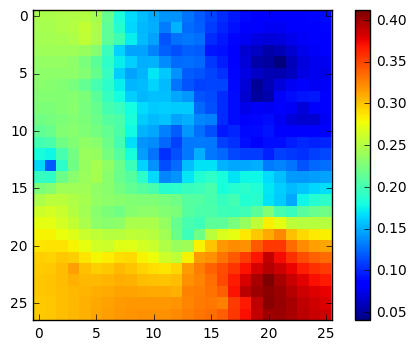

In [57]:
plt.imshow(aot_map, interpolation='None')
plt.colorbar()

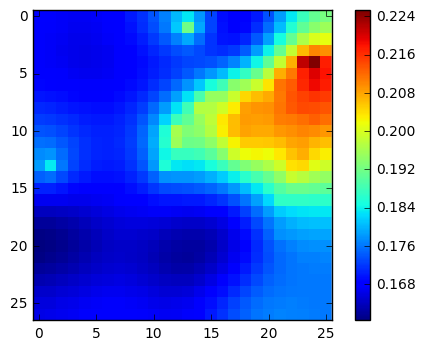

In [58]:
plt.imshow(twv_map, interpolation='None')
plt.colorbar()

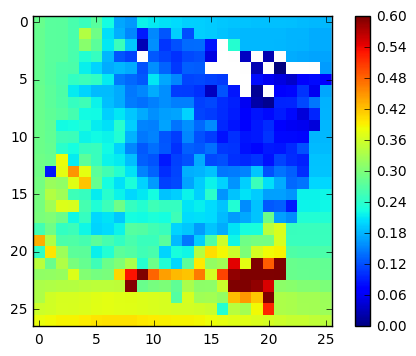

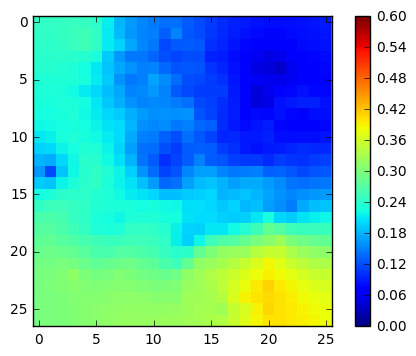

In [55]:
%matplotlib inline
xx = paras[:,0].reshape((27,26)) * 1.
xx[xx==0] = np.nan
xx[cost==0] = np.nan
plt.imshow(xx, interpolation='None',vmin=0,vmax=0.6)
plt.colorbar()
plt.figure()
plt.imshow(aot_map, interpolation='None',vmin=0,vmax=0.6)
plt.colorbar()

In [65]:
%time sur = aot.L8_cor()

/home/ucfafyi/.local/lib/python2.7/site-packages/ipykernel/__main__.py:356: RuntimeWarning: invalid value encountered in less
/home/ucfafyi/.local/lib/python2.7/site-packages/ipykernel/__main__.py:357: RuntimeWarning: invalid value encountered in greater
/home/ucfafyi/.local/lib/python2.7/site-packages/ipykernel/__main__.py:356: RuntimeWarning: invalid value encountered in less
/home/ucfafyi/.local/lib/python2.7/site-packages/ipykernel/__main__.py:357: RuntimeWarning: invalid value encountered in greater
/home/ucfafyi/.local/lib/python2.7/site-packages/ipykernel/__main__.py:356: RuntimeWarning: invalid value encountered in less
/home/ucfafyi/.local/lib/python2.7/site-packages/ipykernel/__main__.py:356: RuntimeWarning: invalid value encountered in less
/home/ucfafyi/.local/lib/python2.7/site-packages/ipykernel/__main__.py:357: RuntimeWarning: invalid value encountered in greater
/home/ucfafyi/.local/lib/python2.7/site-packages/ipykernel/__main__.py:356: RuntimeWarning: invalid value enc

Saving surface reflectance....
CPU times: user 2.82 s, sys: 4.4 s, total: 7.22 s
Wall time: 14min 57s


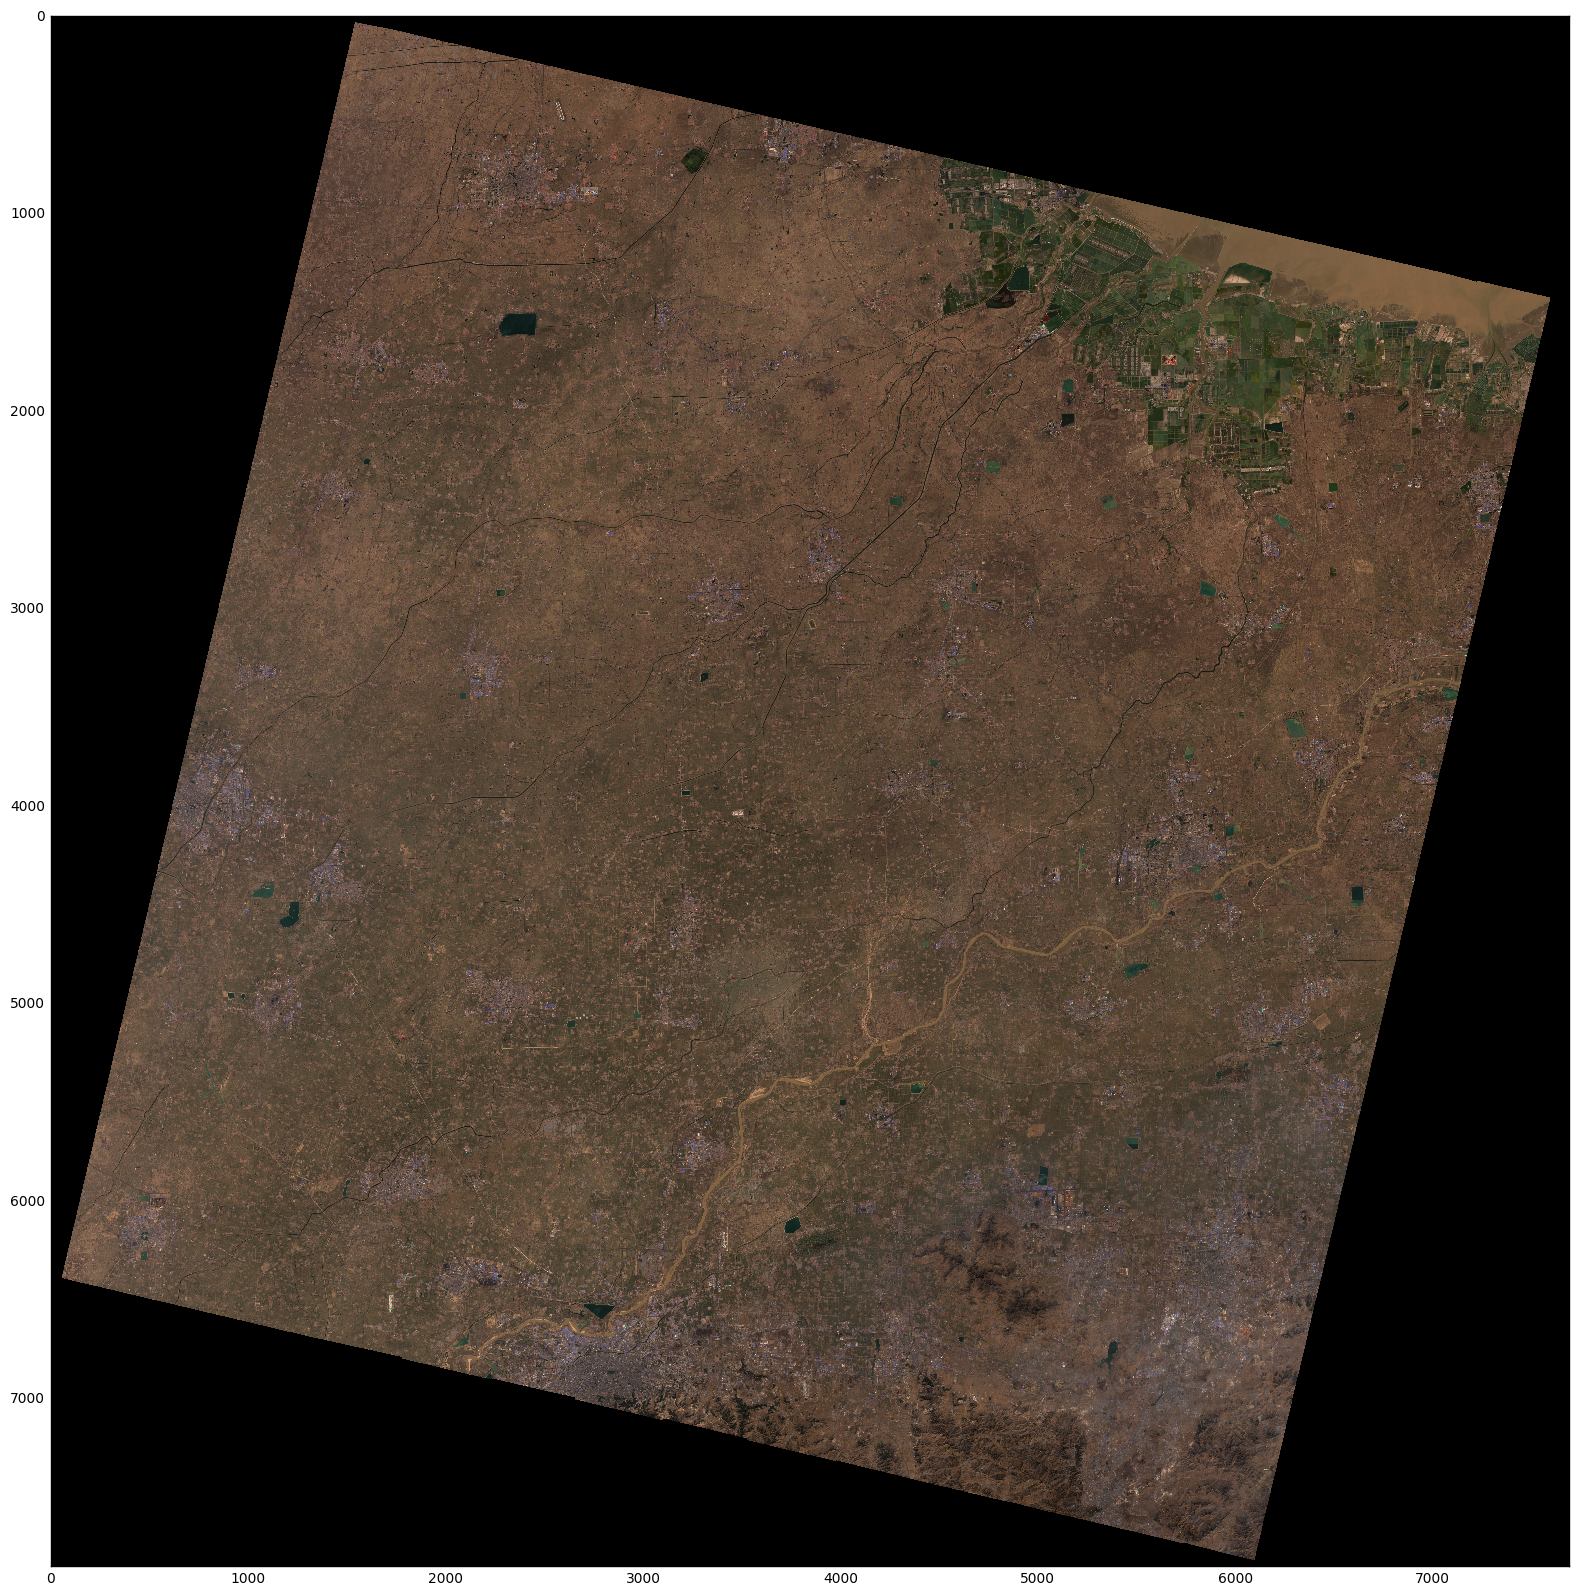

In [683]:
plt.figure(figsize=(20,20))
plt.imshow(np.array([aot.L8_cored[2],aot.L8_cored[1],aot.L8_cored[0]]).transpose(1,2,0)*3, interpolation='None')
plt.savefig(aot.L8_fname+'_sur_ref.pdf', dpi=400)

In [5]:
sur = tifffile.imread('l_data/LC81220342016070LGN00_toa_sur_ref.tiff')

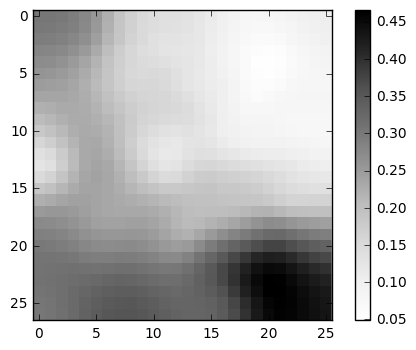

In [66]:
plt.imshow(aot.aot_map, interpolation='None', cmap=plt.cm.get_cmap('Greys'))
plt.colorbar()

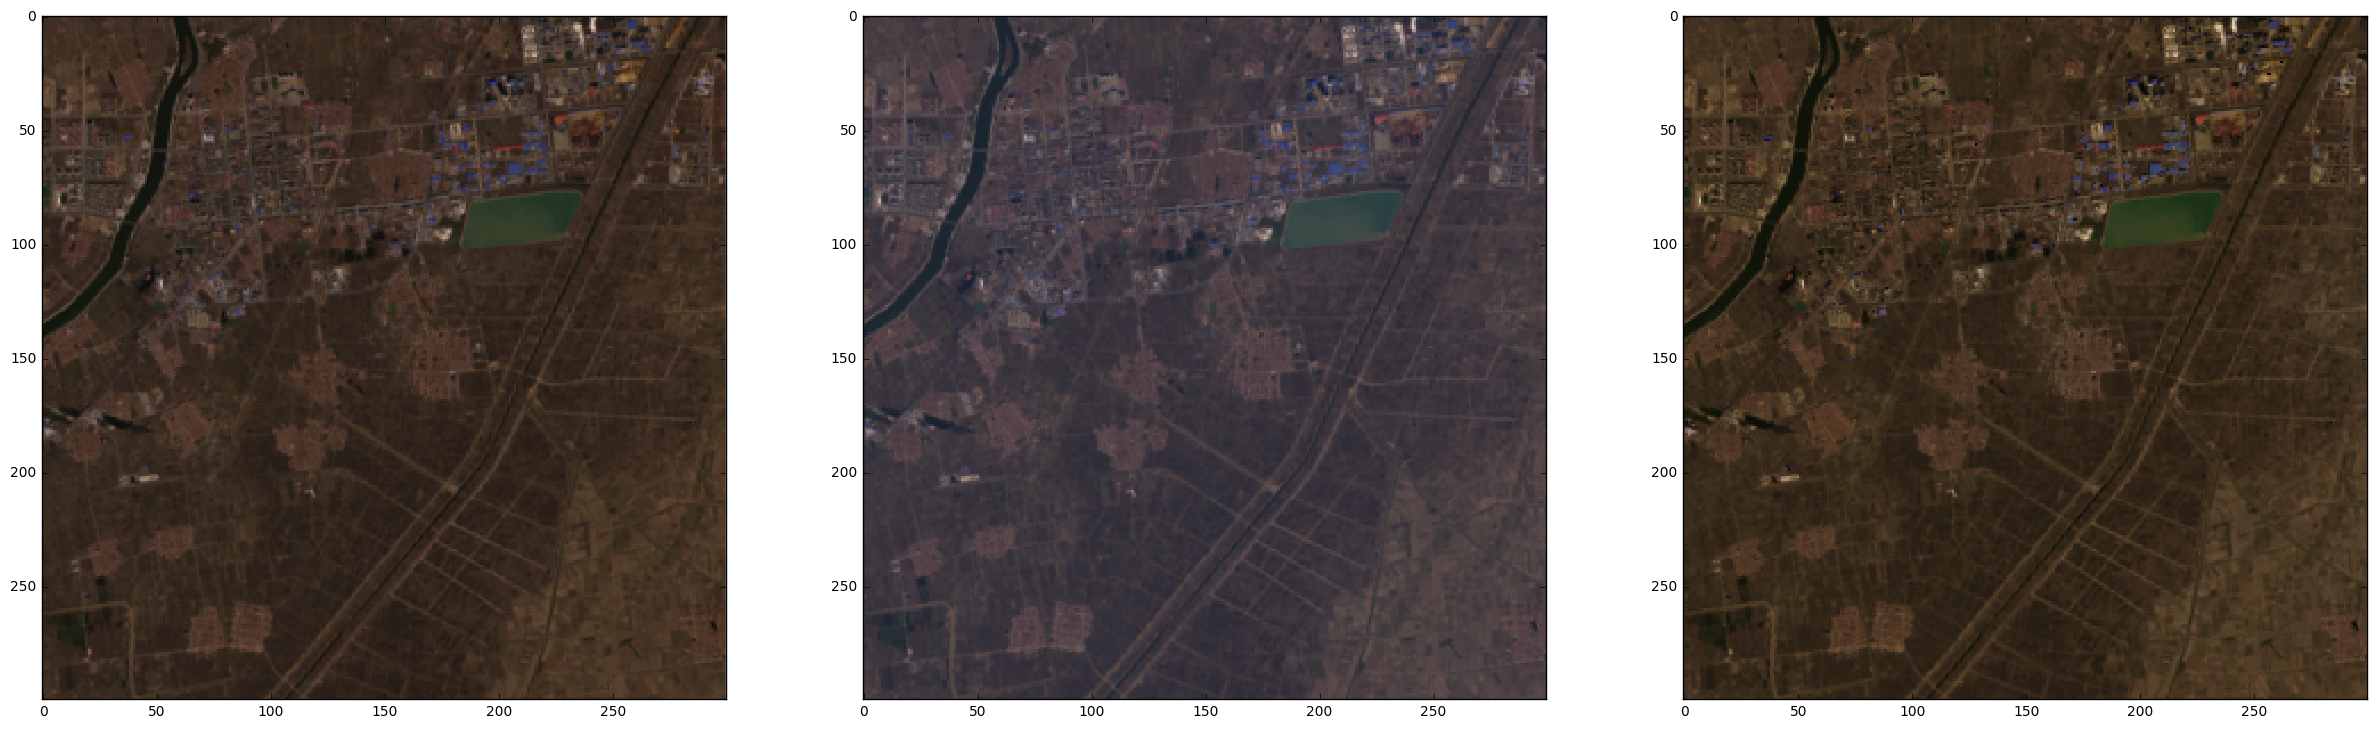

In [67]:
%matplotlib inline
ix,iy = 10,20
toa = np.array([gdal.Open('l_data/'+aot.L8_fname +'_toa_' + 'band%s.tif'%band).ReadAsArray(iy*300,ix*300, 300, 300)*0.0001 for band in [4,3,2]]).transpose(1,2,0)
pat = sur[:,ix*300:(ix+1)*300,iy*300:(iy+1)*300]
l8_sur = np.array([gdal.Open('l_data/'+aot.L8_fname +'_sr_'+ 'band%s.tif'%band).ReadAsArray(iy*300,ix*300, 300, 300)*0.0001 for band in [4,3,2]]).transpose(1,2,0)
l8_sur[l8_sur<0]=np.nan
toa[toa<0]=np.nan
fig = plt.figure(figsize=(30,10))
ax1 = fig.add_subplot(1,3,1)
pat_rgb = np.array([pat[2],pat[1],pat[0]]).transpose(1,2,0)
ax1.imshow(pat_rgb*2, interpolation='None', vmin=0, vmax=0.5)
ax2 = fig.add_subplot(1,3,2)
ax2.imshow(toa*2, interpolation='None',vmin=0, vmax=0.5)
ax3 = fig.add_subplot(1,3,3)
ax3.imshow(l8_sur*2, interpolation='None', vmin=0, vmax=0.5)

(0, 1)

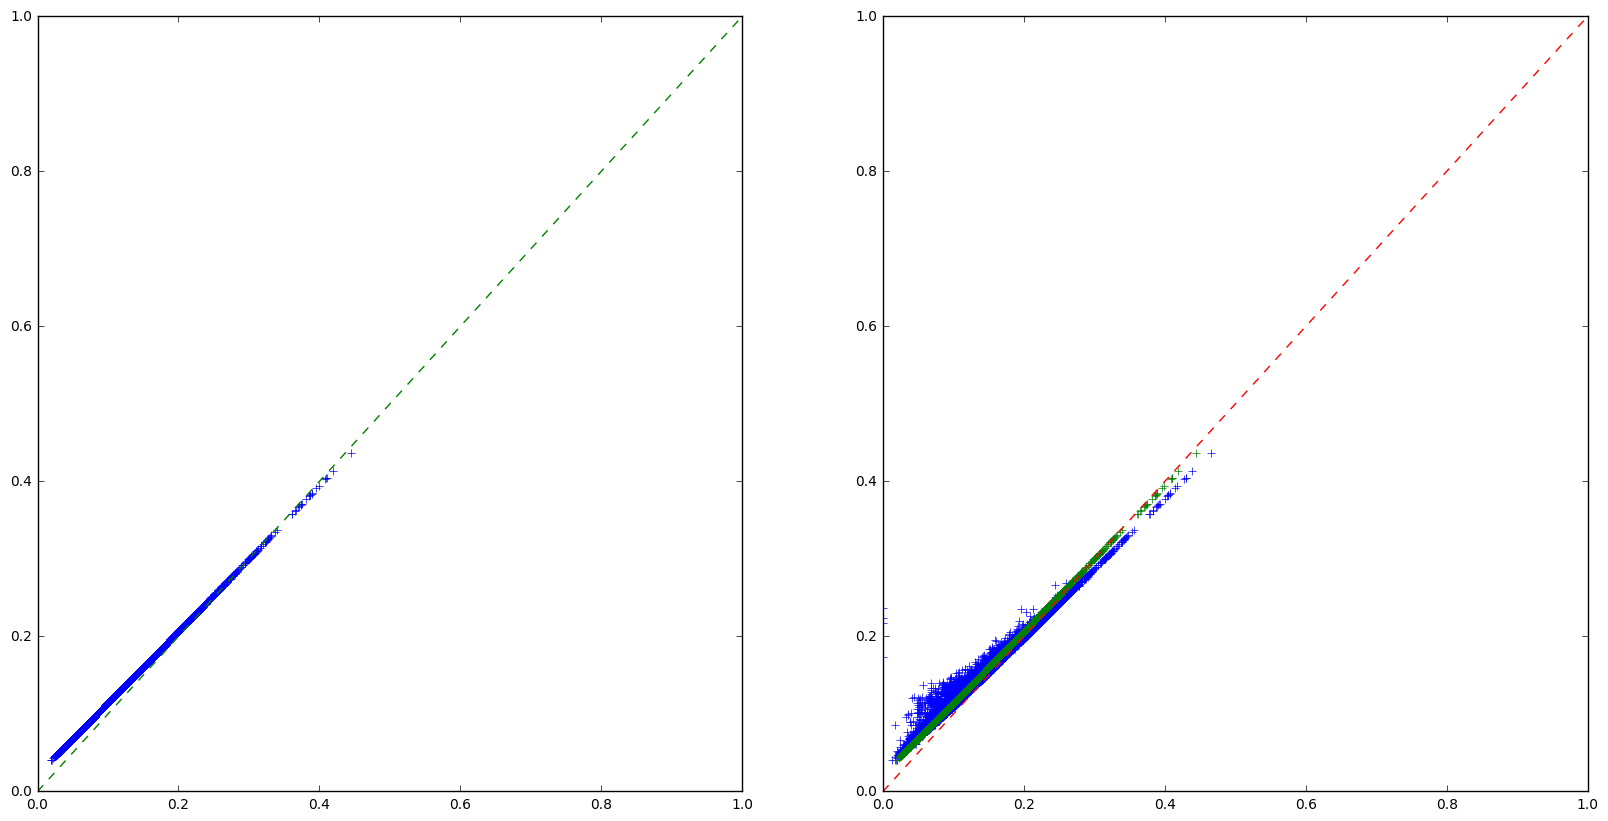

In [687]:
toa = np.array([gdal.Open('l_data/'+aot.L8_fname +'_toa_' + 'band%s.tif'%band).ReadAsArray(iy*300,ix*300, 300, 300)*0.0001 for band in [2,3,4]])
l8_sur = np.array([gdal.Open('l_data/'+aot.L8_fname +'_sr_'+ 'band%s.tif'%band).ReadAsArray(iy*300,ix*300, 300, 300)*0.0001 for band in [2,3,4]])
fig = plt.figure(figsize=(20,10))
band = 2
ax1 = fig.add_subplot(1,2,1)
ax1.plot(pat[band].ravel(), toa[band].ravel(), '+')
ax1.plot([0,1], [0,1], '--')
ax1.set_xlim(0,1)
ax1.set_ylim(0,1)
ax2 = fig.add_subplot(1,2,2)
ax2.plot(l8_sur[band].ravel(), toa[band].ravel(), '+')
ax2.plot(pat[band].ravel(), toa[band].ravel(), '+')
ax2.plot([0,1], [0,1], '--')
ax2.set_xlim(0,1)
ax2.set_ylim(0,1)

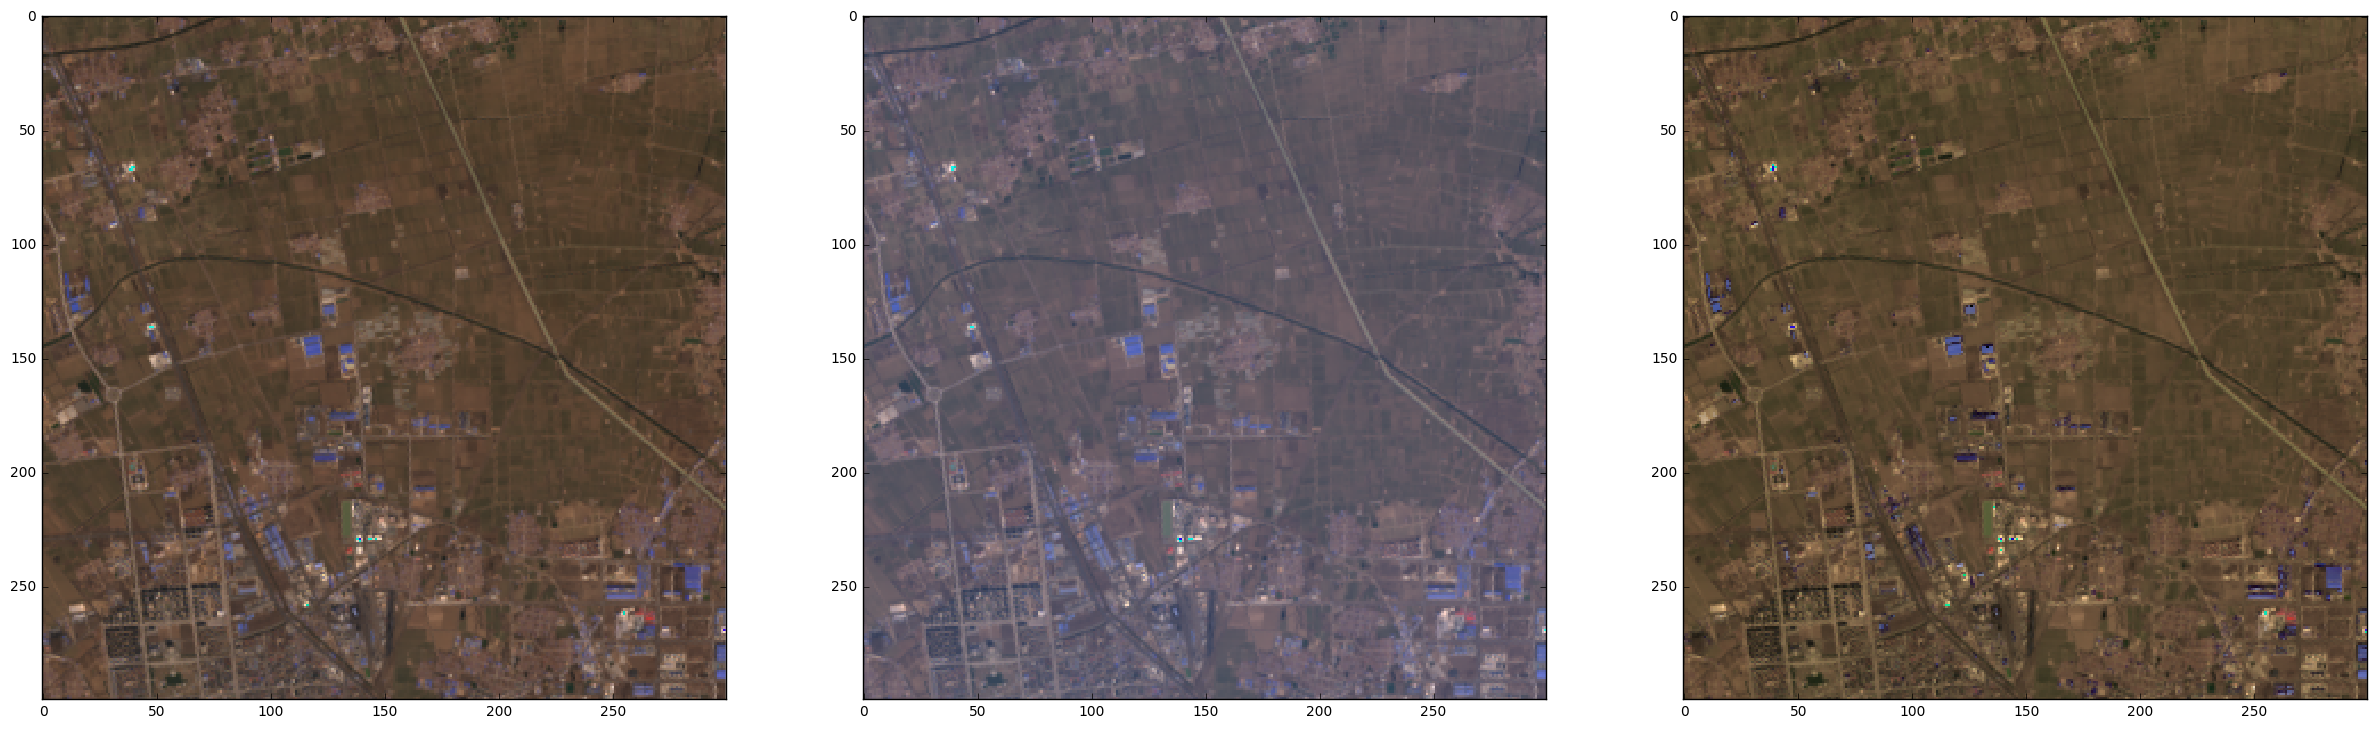

In [81]:
ix,iy = 16, 20
toa = np.array([gdal.Open('l_data/'+aot.L8_fname +'_toa_' + 'band%s.tif'%band).ReadAsArray(iy*300,ix*300, 300, 300)*0.0001 for band in [4,3,2]]).transpose(1,2,0)
pat = aot.L8_patch_correction((ix,iy))[1]
l8_sur = np.array([gdal.Open('l_data/'+aot.L8_fname +'_sr_'+ 'band%s.tif'%band).ReadAsArray(iy*300,ix*300, 300, 300)*0.0001 for band in [4,3,2]]).transpose(1,2,0)
l8_sur[l8_sur<0]=np.nan
toa[toa<0]=np.nan
fig = plt.figure(figsize=(30,10))
ax1 = fig.add_subplot(1,3,1)
pat_rgb = np.array([pat[2],pat[1],pat[0]]).transpose(1,2,0)
ax1.imshow(pat_rgb*3, interpolation='None', vmin=0, vmax=0.5)
ax2 = fig.add_subplot(1,3,2)
ax2.imshow(toa*3, interpolation='None',vmin=0, vmax=0.5)
ax3 = fig.add_subplot(1,3,3)
ax3.imshow(l8_sur*3, interpolation='None', vmin=0, vmax=0.5)

In [651]:
pat[1].shape, toa.shape

((300, 300), (300, 300, 3))

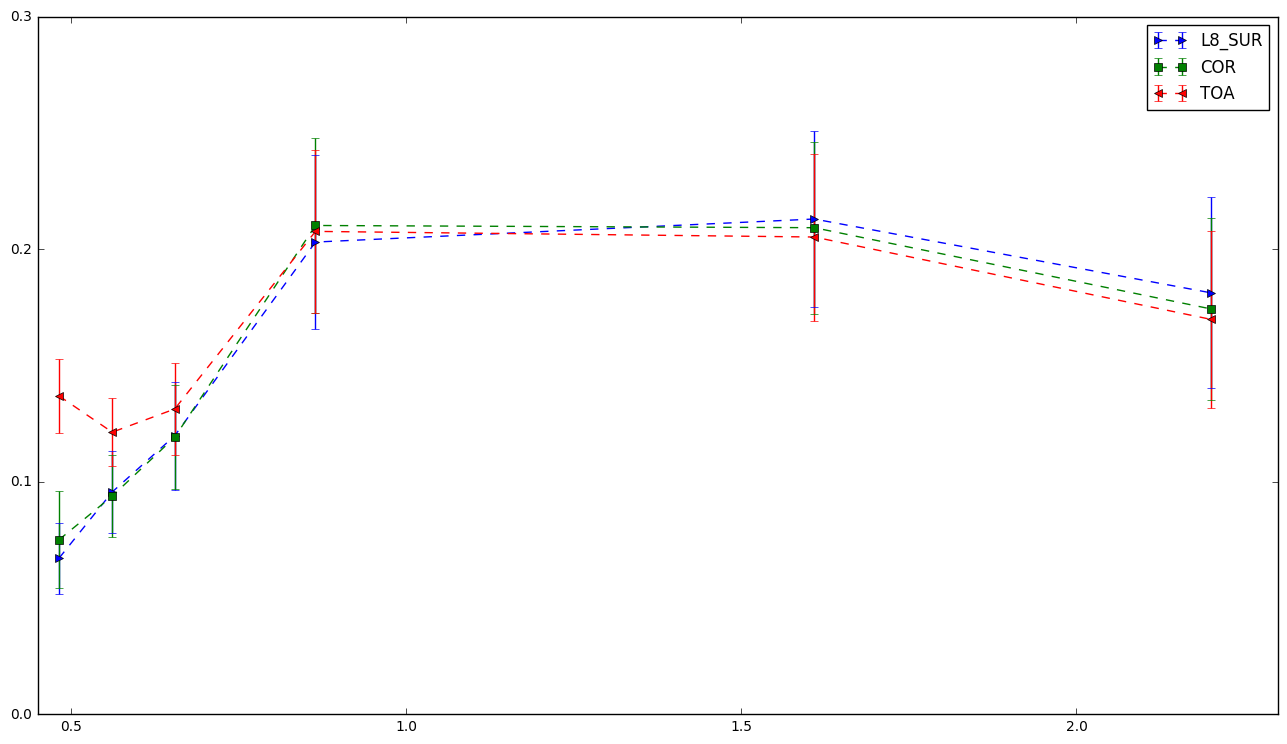

In [82]:
l8_sur = np.array([gdal.Open('l_data/'+aot.L8_fname +'_sr_'+ 'band%s.tif'%band).ReadAsArray(iy*300,ix*300, 300, 300)*0.0001 for band in [2,3,4,5,6,7]])
toa = np.array([gdal.Open('l_data/'+aot.L8_fname +'_toa_' + 'band%s.tif'%band).ReadAsArray(iy*300,ix*300, 300, 300)*0.0001 for band in [2,3,4,5,6,7]])
l8_sur[l8_sur<0]=np.nan
toa[toa<0]=np.nan

fig = plt.figure(figsize=(16,9))
wl = np.array([482.04,561.41,654.59,864.67,1608.86,2200.73])/1000
ax = fig.add_subplot(1,1,1)
ax.errorbar(wl,  y = np.nanmean(l8_sur,axis=(1,2)),yerr=np.nanstd(l8_sur,axis=(1,2)), lw=1, label='L8_SUR', fmt='>--')
ax.errorbar(wl,  y = np.nanmean(pat,axis=(1,2)), yerr=np.nanstd(pat, axis=(1,2)), lw=1, label='COR', fmt='s--')
ax.errorbar(wl, y =  np.nanmean(toa,axis=(1,2)),yerr=np.nanstd(toa,axis=(1,2)), lw=1, label='TOA', fmt='<--')
#pretty_axes(ax)
ax.set_yticks(np.arange(0, np.nanmax(np.nanmean(toa,axis=(1,2)))+0.1, 0.1))
ax.set_xlim(0.45, 2.3)
plt.legend()

In [692]:
l8_sur = np.array([gdal.Open('l_data/'+aot.L8_fname +'_sr_'+ 'band%s.tif'%band).ReadAsArray()*0.0001 for band in [2,3,4,5,6,7]])
toa = np.array([gdal.Open('l_data/'+aot.L8_fname +'_toa_' + 'band%s.tif'%band).ReadAsArray()*0.0001 for band in [2,3,4,5,6,7]])
l8_sur[l8_sur<0]=np.nan
toa[toa<0]=np.nan

(0, 1)

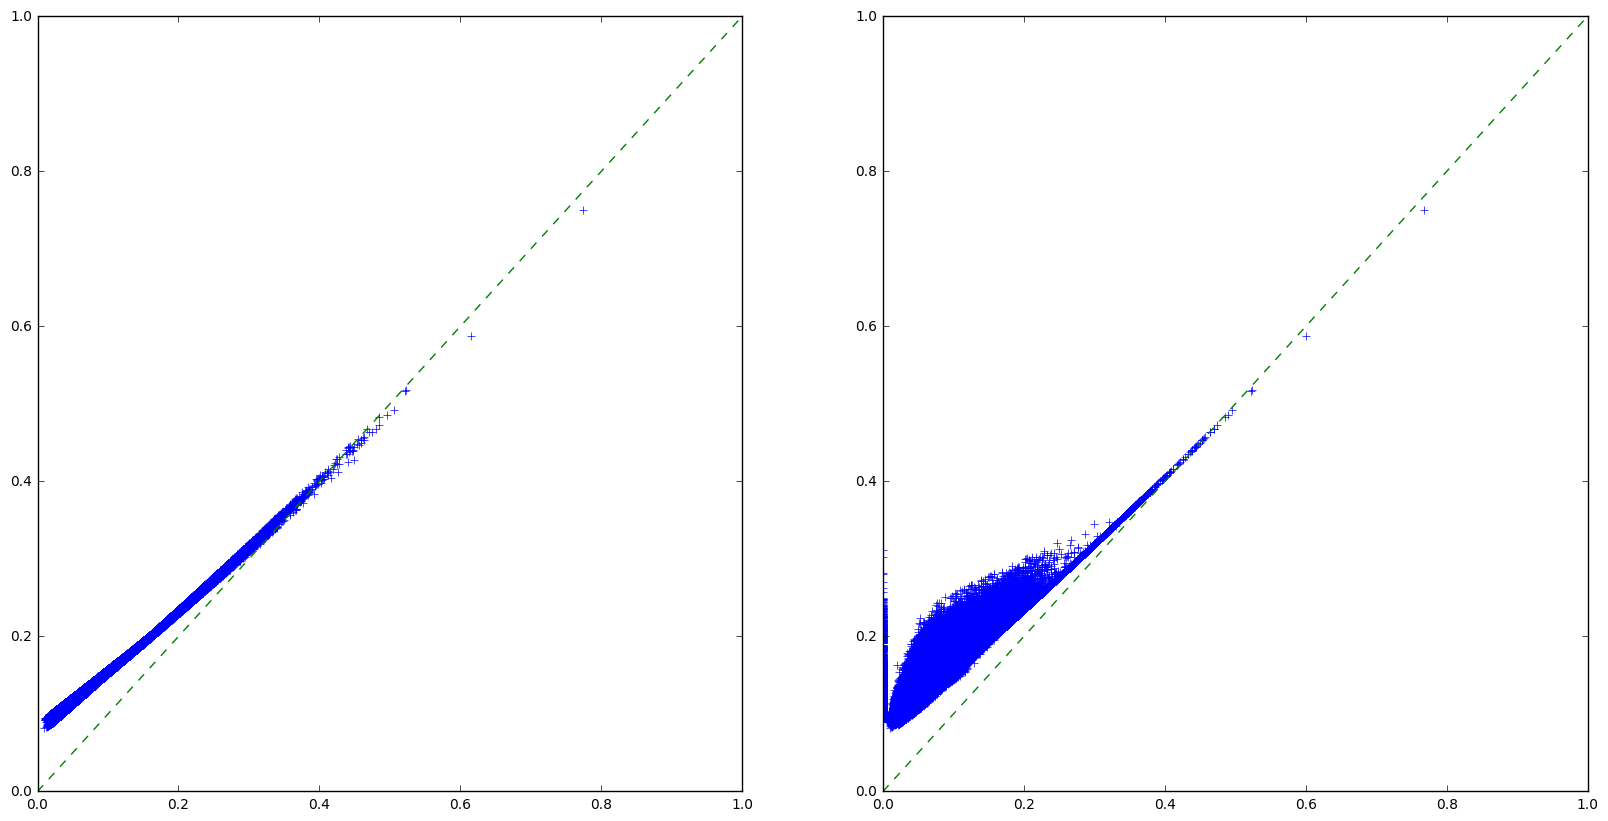

In [693]:
band = 0
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(sur[band].ravel(), toa[band].ravel(), '+')
ax1.plot([0,1], [0,1], '--')
ax1.set_xlim(0,1)
ax1.set_ylim(0,1)
ax2 = fig.add_subplot(1,2,2)
ax2.plot(l8_sur[band].ravel(), toa[band].ravel(), '+')
ax2.plot([0,1], [0,1], '--')
ax2.set_xlim(0,1)
ax2.set_ylim(0,1)

(0, 1)

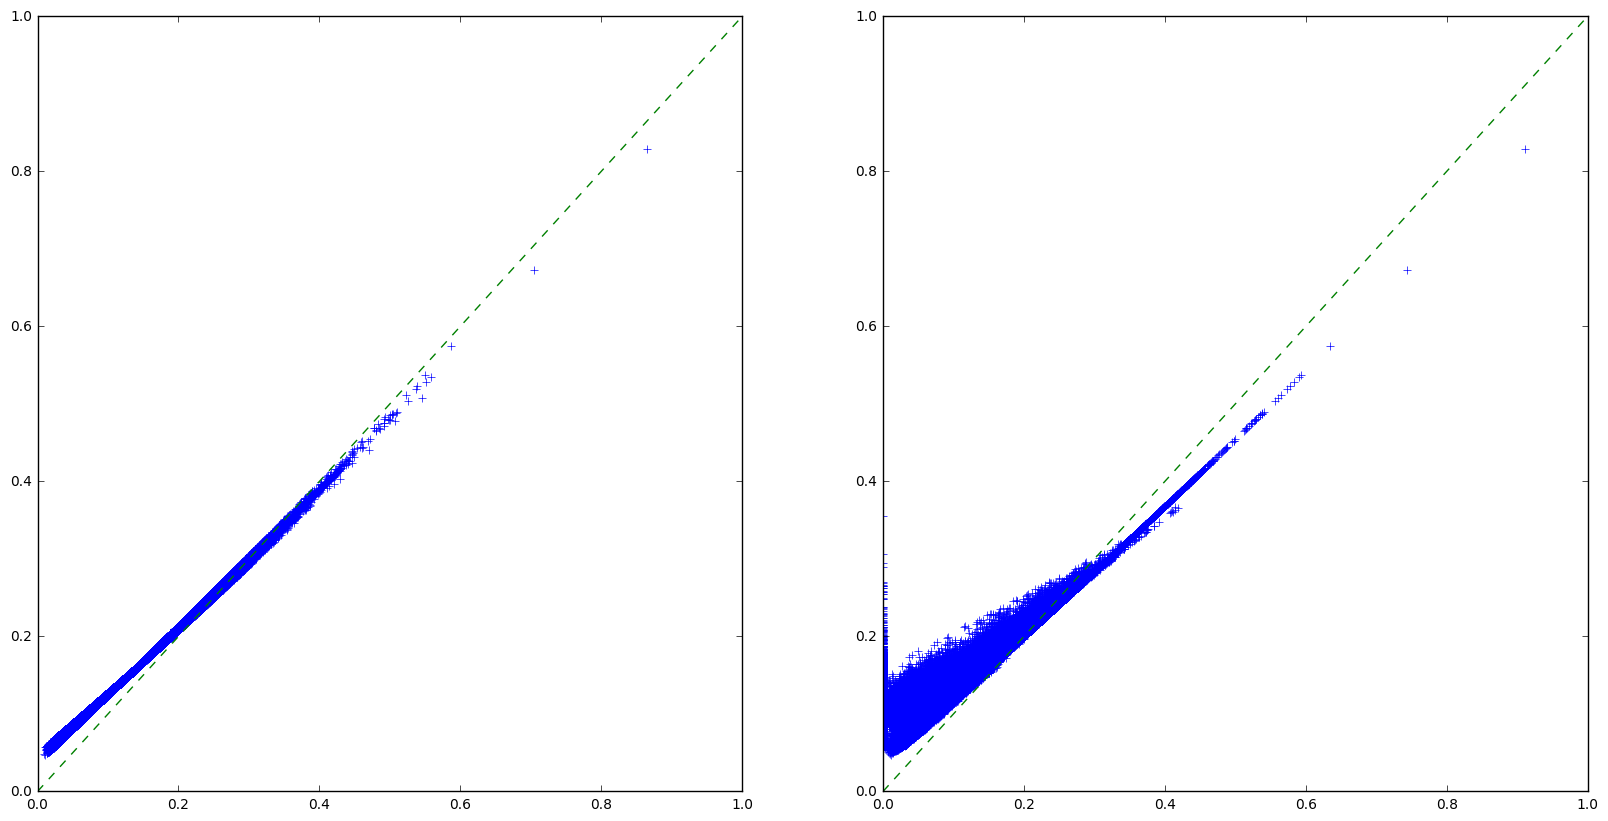

In [694]:
band = 1
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(sur[band].ravel(), toa[band].ravel(), '+')
ax1.plot([0,1], [0,1], '--')
ax1.set_xlim(0,1)
ax1.set_ylim(0,1)
ax2 = fig.add_subplot(1,2,2)
ax2.plot(l8_sur[band].ravel(), toa[band].ravel(), '+')
ax2.plot([0,1], [0,1], '--')
ax2.set_xlim(0,1)
ax2.set_ylim(0,1)

(0, 1)

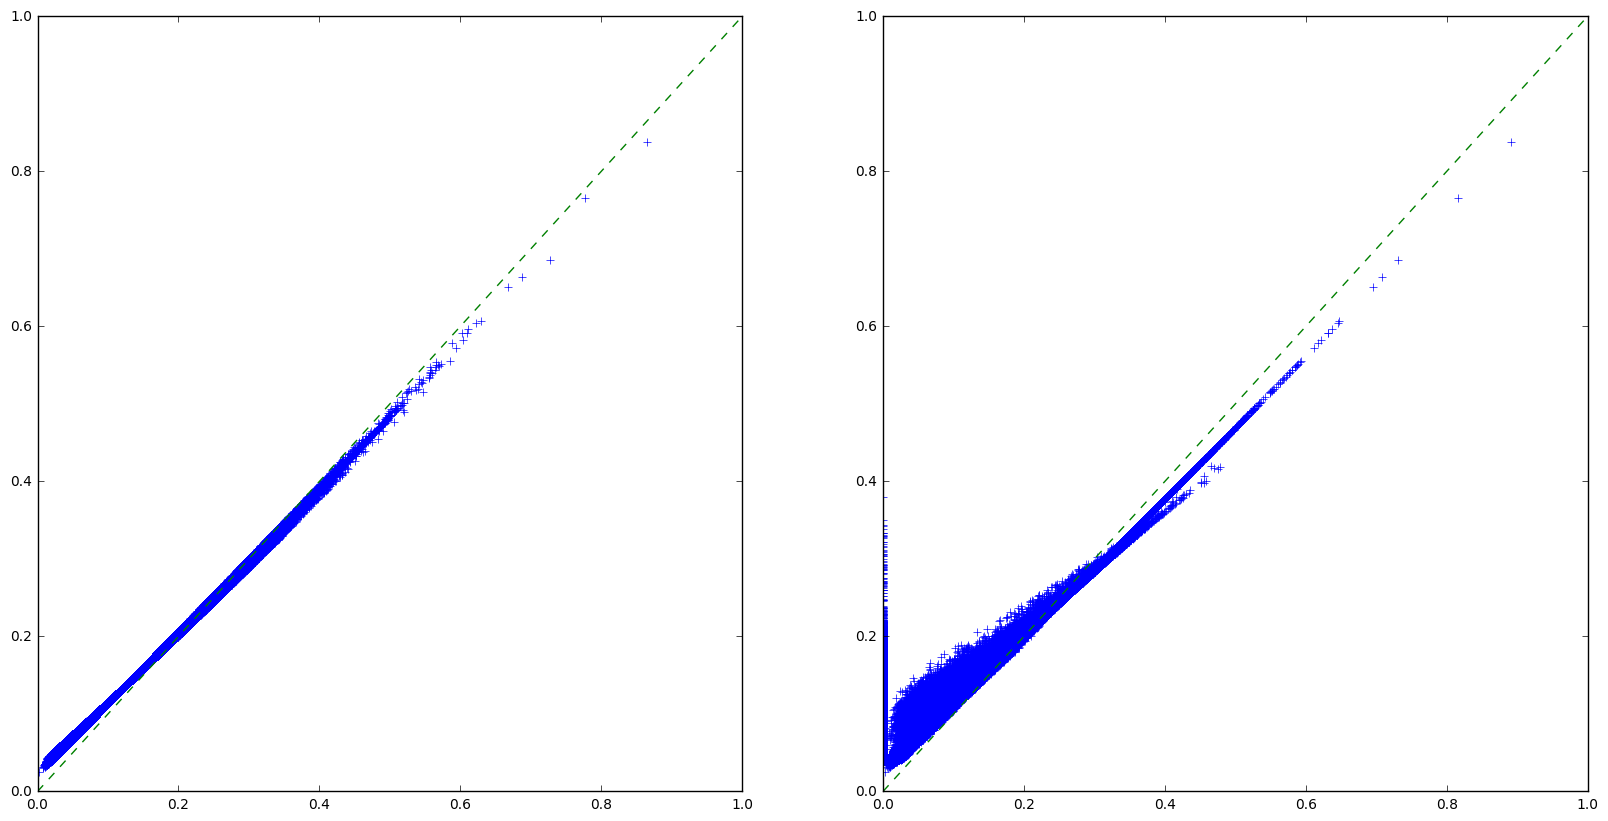

In [695]:
band = 2
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(sur[band].ravel(), toa[band].ravel(), '+')
ax1.plot([0,1], [0,1], '--')
ax1.set_xlim(0,1)
ax1.set_ylim(0,1)
ax2 = fig.add_subplot(1,2,2)
ax2.plot(l8_sur[band].ravel(), toa[band].ravel(), '+')
ax2.plot([0,1], [0,1], '--')
ax2.set_xlim(0,1)
ax2.set_ylim(0,1)

(0, 1)

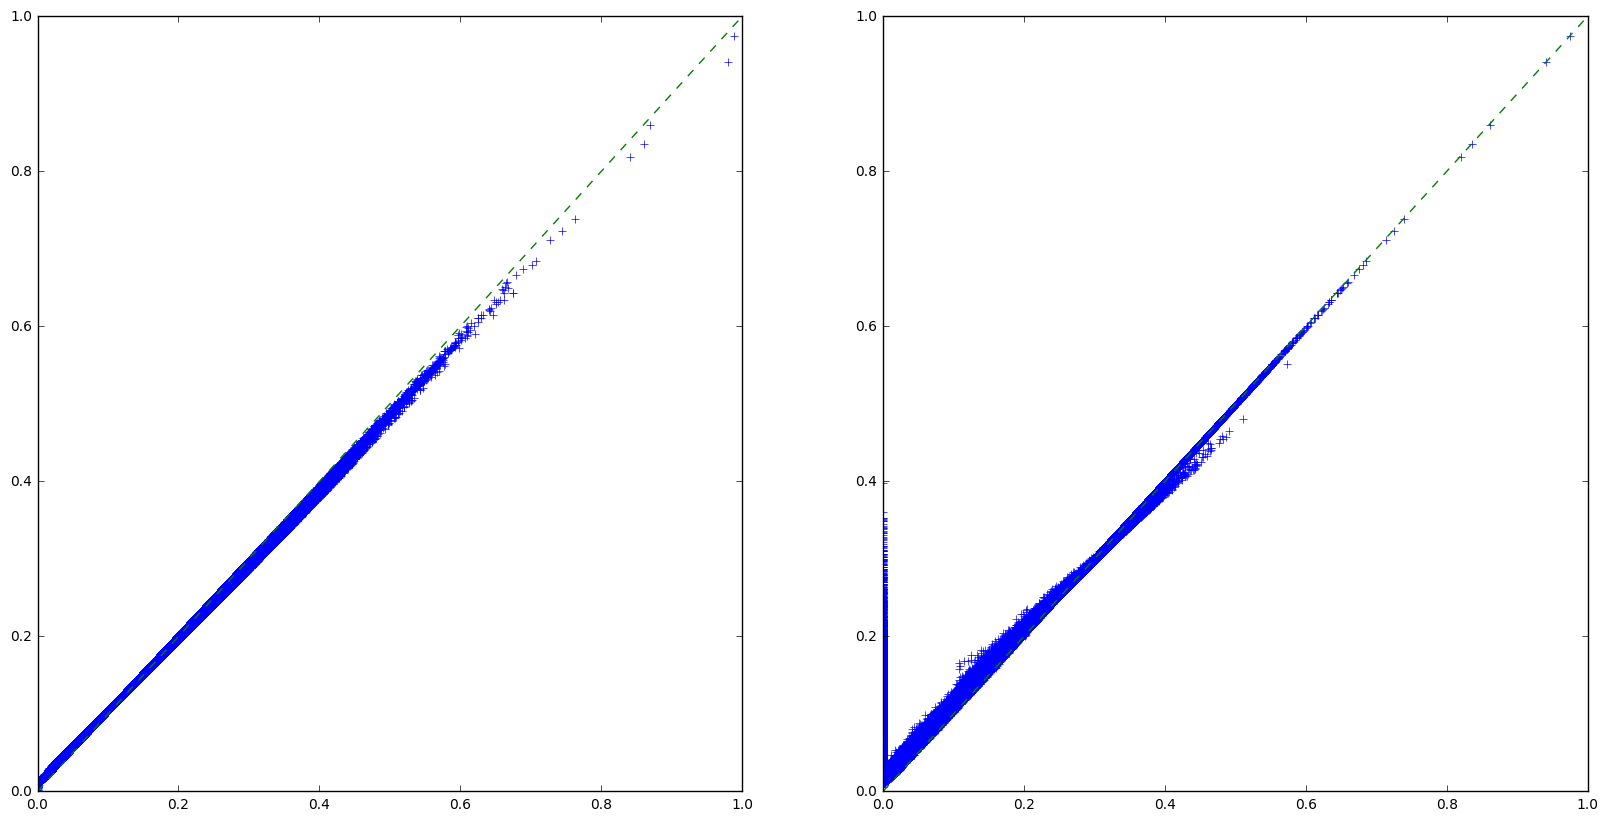

In [696]:
band = 3
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(sur[band].ravel(), toa[band].ravel(), '+')
ax1.plot([0,1], [0,1], '--')
ax1.set_xlim(0,1)
ax1.set_ylim(0,1)
ax2 = fig.add_subplot(1,2,2)
ax2.plot(l8_sur[band].ravel(), toa[band].ravel(), '+')
ax2.plot([0,1], [0,1], '--')
ax2.set_xlim(0,1)
ax2.set_ylim(0,1)

(0, 1)

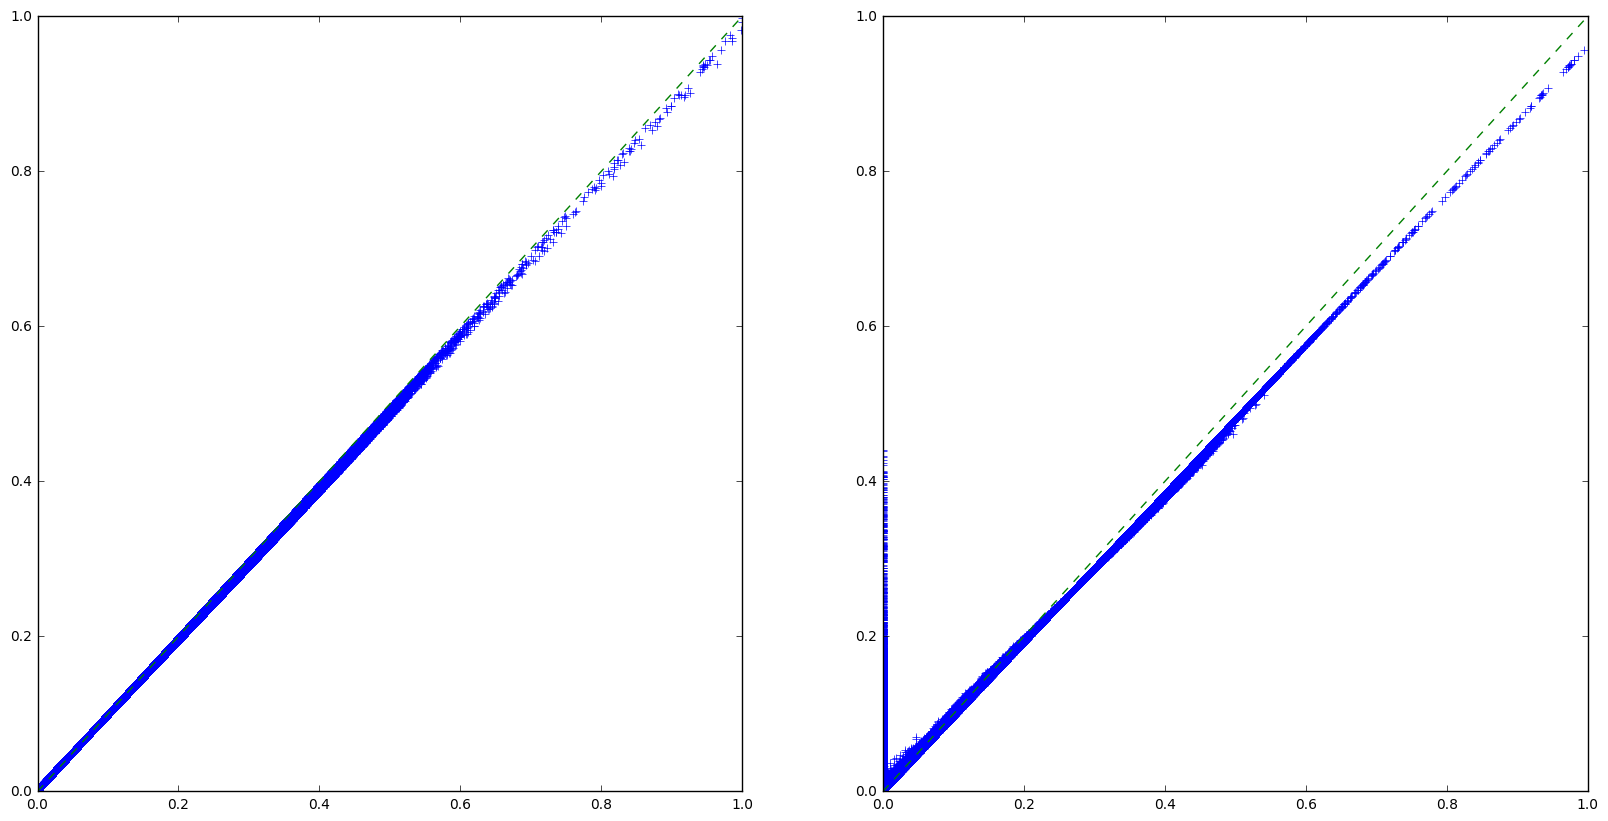

In [697]:
band = 4
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(sur[band].ravel(), toa[band].ravel(), '+')
ax1.plot([0,1], [0,1], '--')
ax1.set_xlim(0,1)
ax1.set_ylim(0,1)
ax2 = fig.add_subplot(1,2,2)
ax2.plot(l8_sur[band].ravel(), toa[band].ravel(), '+')
ax2.plot([0,1], [0,1], '--')
ax2.set_xlim(0,1)
ax2.set_ylim(0,1)

(0, 1)

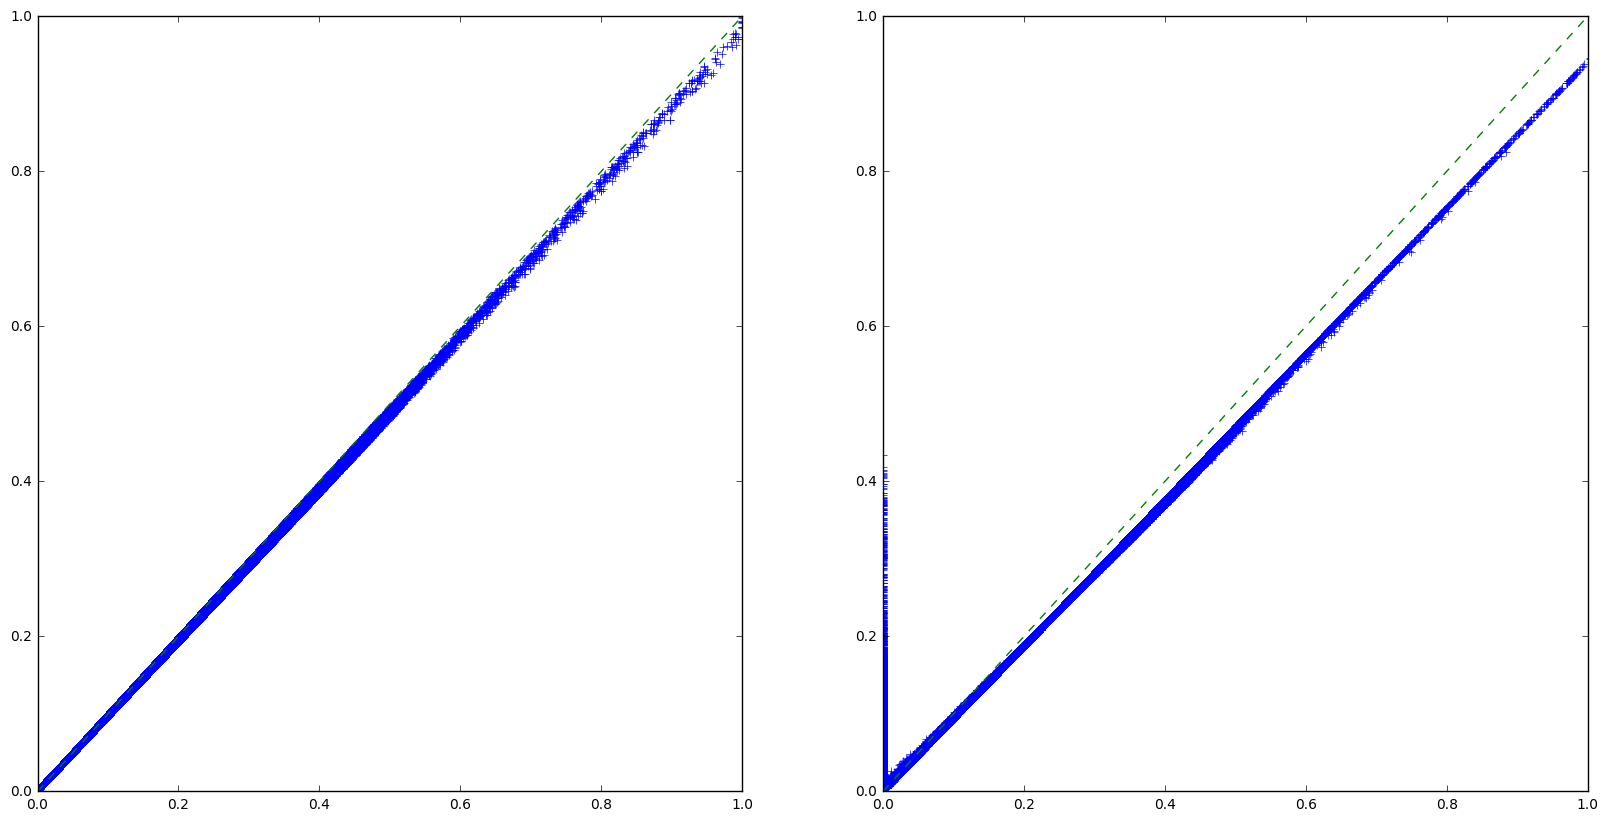

In [698]:
band = 5
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(sur[band].ravel(), toa[band].ravel(), '+')
ax1.plot([0,1], [0,1], '--')
ax1.set_xlim(0,1)
ax1.set_ylim(0,1)
ax2 = fig.add_subplot(1,2,2)
ax2.plot(l8_sur[band].ravel(), toa[band].ravel(), '+')
ax2.plot([0,1], [0,1], '--')
ax2.set_xlim(0,1)
ax2.set_ylim(0,1)